# Model Comparison: Lead Price 7-Day Return Classification (Macro Features)

This notebook compares the performance of all classification models on predicting whether 7-day returns of lead prices will be positive or negative using macro features and top PCA-selected features.

## Models Included:
1. Logistic Regression
2. Random Forest
3. SVM
4. MLP
5. RNN (LSTM)

## Target:
Binary classification: 1 if return_7d > 0, else 0

## Features Used (Top 20 PCA Features):
'dxy_ma_diff_20_5', 'dxy_return_7d', 'copper_vol_7d', 'lead_to_copper_ratio', 'future_return', 'corr_lead_dxy_30d', 'returns', 'copper_ma_diff_20_5', 'yield_change_7d', 'oil_dxy_interaction', 'corr_lead_copper_30d', 'wti_vol_7d', 'divergence_lc', 'RSI', 'regime_dxy_yield', 'wti_return_7d', 'MACD30', 'copper_return_7d', 'future_return_7d', 'rolling_volatility'

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import os
import warnings
import time
from datetime import datetime
warnings.filterwarnings('ignore')

# Add project root to Python path
try:
    current_dir = Path.cwd()
    if current_dir.name == 'notebooks':
        project_root = current_dir.parent
    else:
        project_root = current_dir
except:
    project_root = Path(r'C:\Project_Macro_Impact_On_Lead')

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

os.chdir(project_root)

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Import data splitting function
from src.data.train_test_split_walk_forward import train_test_split_time_series

# Import all classification models
from src.classification.clf_baseline_linear import train_logistic_regression
from src.classification.clf_tree_models import train_random_forest
from src.classification.clf_svm_knn import train_svm, train_knn
from src.classification.clf_mlp import train_mlp
from src.classification.clf_rnn import train_rnn

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
# Also set Python's random seed
import random
random.seed(RANDOM_SEED)
# Set TensorFlow random seed (if available)
try:
    import tensorflow as tf
    tf.random.set_seed(RANDOM_SEED)
except ImportError:
    pass

print("All imports successful")
print(f"Random seed set to {RANDOM_SEED} for reproducibility")



Bad key text.latex.preview in file c:\Users\34663\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.5/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file c:\Users\34663\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.5/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file c:\Users\34663\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default 

All imports successful
Random seed set to 42 for reproducibility


In [2]:
# Load data
df = pd.read_csv("data_processed/all_features_with_macro.csv")

print(f"Data shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
df.head()


Data shape: (6110, 39)
Columns: ['Date', 'LOPBDY LME Comdty', 'returns', 'MA7', 'MA30', 'rolling_volatility', 'EMA5', 'EMA15', 'EMA30', 'MACD5', 'MACD15', 'MACD30', 'RSI', 'BB_upper', 'BB_middle', 'BB_lower', 'return_7d', 'target', 'future_return', 'future_MA7', 'future_MA30', 'future_rolling_volatility', 'future_return_7d', 'dxy_return_7d', 'yield_change_7d', 'dxy_ma_diff_20_5', 'copper_return_7d', 'wti_return_7d', 'lead_to_copper_ratio', 'copper_ma_diff_20_5', 'copper_vol_7d', 'wti_vol_7d', 'corr_lead_copper_30d', 'corr_lead_dxy_30d', 'IDF', 'divergence_lc', 'oil_dxy_interaction', 'joint_momentum', 'regime_dxy_yield']


,Date,LOPBDY LME Comdty,returns,MA7,MA30,rolling_volatility,EMA5,EMA15,EMA30,MACD5,...,copper_ma_diff_20_5,copper_vol_7d,wti_vol_7d,corr_lead_copper_30d,corr_lead_dxy_30d,IDF,divergence_lc,oil_dxy_interaction,joint_momentum,regime_dxy_yield
0,2001-01-22,484.0,0.016807,466.642857,465.850000,0.016046,472.477942,468.758402,466.470573,5.445235,...,-0.002127,0.021711,0.024679,0.227243,-0.225959,0.053504,0.000993,0.000293,0.045518,1.0
1,2001-01-23,494.0,0.020661,470.428571,466.750000,0.016374,479.651961,471.913602,468.246665,10.621677,...,-0.002719,0.021711,0.041656,0.217905,-0.193981,0.012298,0.037864,0.000027,0.082308,1.0
2,2001-01-24,490.5,-0.007085,473.857143,467.533333,0.016455,483.267974,474.236902,469.682364,12.647340,...,-0.000371,0.021846,0.041362,0.227842,-0.223879,-0.019303,0.054526,-0.000706,0.043869,1.0
3,2001-01-25,489.0,-0.003058,479.000000,468.383333,0.016389,485.178650,476.082289,470.928663,13.196581,...,0.001295,0.019527,0.041402,0.233019,-0.223084,-0.007825,0.062501,-0.000444,0.096440,1.0
4,2001-01-26,500.0,0.022495,485.642857,469.933333,0.016184,490.119100,479.072003,472.804233,16.061629,...,0.002259,0.019397,0.040938,0.239768,-0.214631,0.006702,0.093516,0.000026,0.111556,1.0


In [3]:
# Prepare features and target variable
# Use top 20 PCA features from macro analysis
feature_cols = ['dxy_ma_diff_20_5', 'dxy_return_7d', 'copper_vol_7d', 
                'future_return', 'corr_lead_dxy_30d', 'returns', 'copper_ma_diff_20_5', 
                'yield_change_7d', 'oil_dxy_interaction', 'corr_lead_copper_30d', 'wti_vol_7d', 
                'divergence_lc', 'RSI', 'regime_dxy_yield', 'wti_return_7d', 'MACD30', 
                'copper_return_7d', 'future_return_7d', 'rolling_volatility']
target_col = 'target'

# Check if all features exist in the dataframe
missing_features = [col for col in feature_cols if col not in df.columns]
if missing_features:
    print(f"Warning: Missing features: {missing_features}")
    print(f"Available columns: {df.columns.tolist()}")
    # Use only available features
    feature_cols = [col for col in feature_cols if col in df.columns]
    print(f"Using {len(feature_cols)} available features")

X = df[feature_cols].values
y = df[target_col].values

# Handle missing values
valid_mask = ~(np.isnan(X).any(axis=1) | np.isnan(y))
X = X[valid_mask]
y = y[valid_mask]

print(f"Processed data shape: X={X.shape}, y={y.shape}")
print(f"Features used ({len(feature_cols)}): {feature_cols}")
print(f"Missing values removed: {len(df) - len(X)} rows")
print(f"Target distribution: {pd.Series(y).value_counts().to_dict()}")
print(f"Target percentage: {y.mean()*100:.2f}% positive (1)")


Processed data shape: X=(6110, 19), y=(6110,)
Features used (19): ['dxy_ma_diff_20_5', 'dxy_return_7d', 'copper_vol_7d', 'future_return', 'corr_lead_dxy_30d', 'returns', 'copper_ma_diff_20_5', 'yield_change_7d', 'oil_dxy_interaction', 'corr_lead_copper_30d', 'wti_vol_7d', 'divergence_lc', 'RSI', 'regime_dxy_yield', 'wti_return_7d', 'MACD30', 'copper_return_7d', 'future_return_7d', 'rolling_volatility']
Missing values removed: 0 rows
Target distribution: {1: 3122, 0: 2988}
Target percentage: 51.10% positive (1)


In [4]:
# Time series train-test split
train_X, train_y, test_X, test_y = train_test_split_time_series(X, y, test_size=0.2)

# For fair comparison, align test sets to match RNN requirements
# RNN needs seq_length samples to create sequences, so it skips first (seq_length-1) test samples
seq_length = 10  # Match the seq_length used in RNN
test_X_aligned = test_X[seq_length - 1:]
test_y_aligned = test_y[seq_length - 1:]

print(f"Training set size: {len(train_X)}")
print(f"Original test set size: {len(test_X)}")
print(f"Aligned test set size (for fair comparison): {len(test_X_aligned)}")
print(f"Skipped first {seq_length - 1} test samples to align with sequence models")
print(f"Train/Test ratio: {len(train_X)/len(test_X_aligned):.2f}:1")
print(f"\nTraining target distribution: {pd.Series(train_y).value_counts().to_dict()}")
print(f"Test target distribution: {pd.Series(test_y_aligned).value_counts().to_dict()}")


Training set size: 4888
Original test set size: 1222
Aligned test set size (for fair comparison): 1213
Skipped first 9 test samples to align with sequence models
Train/Test ratio: 4.03:1

Training target distribution: {1: 2503, 0: 2385}
Test target distribution: {1: 617, 0: 596}


## Run All Models

This cell trains all classification models and collects their results.

In [5]:
# Initialize results dictionary
results = {}
model_times = {}

print("=" * 80)
print("Training All Classification Models (Macro Features)")
print("=" * 80)
print(f"Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
print(f"Note: All models will evaluate on {len(test_X_aligned)} aligned test samples for fair comparison\n")

# 1. Logistic Regression
print("[1/6] Logistic Regression...", end=" ")
start_time = time.time()
try:
    results['logistic'] = train_logistic_regression(train_X, train_y, test_X_aligned, test_y_aligned)
    elapsed = time.time() - start_time
    model_times['logistic'] = elapsed
    print(f"Done (Accuracy: {results['logistic']['accuracy']:.4f}, F1: {results['logistic']['f1']:.4f}, AUC: {results['logistic']['auc']:.4f}, Time: {elapsed:.2f}s)")
except Exception as e:
    error_msg = str(e) if e is not None else "Unknown error (exception was None)"
    if not error_msg or error_msg == "None":
        error_msg = f"Error type: {type(e).__name__}"
    print(f"Failed: {error_msg[:100]}")

# 2. Random Forest
print("[2/6] Random Forest...", end=" ")
start_time = time.time()
try:
    results['random_forest'] = train_random_forest(train_X, train_y, test_X_aligned, test_y_aligned)
    elapsed = time.time() - start_time
    model_times['random_forest'] = elapsed
    print(f"Done (Accuracy: {results['random_forest']['accuracy']:.4f}, F1: {results['random_forest']['f1']:.4f}, AUC: {results['random_forest']['auc']:.4f}, Time: {elapsed:.2f}s)")
except Exception as e:
    error_msg = str(e) if e is not None else "Unknown error (exception was None)"
    if not error_msg or error_msg == "None":
        error_msg = f"Error type: {type(e).__name__}"
    print(f"Failed: {error_msg[:100]}")

# 3. SVM
print("[3/6] SVM...", end=" ")
start_time = time.time()
try:
    results['svm'] = train_svm(train_X, train_y, test_X_aligned, test_y_aligned)
    elapsed = time.time() - start_time
    model_times['svm'] = elapsed
    print(f"Done (Accuracy: {results['svm']['accuracy']:.4f}, F1: {results['svm']['f1']:.4f}, AUC: {results['svm']['auc']:.4f}, Time: {elapsed:.2f}s)")
except Exception as e:
    error_msg = str(e) if e is not None else "Unknown error (exception was None)"
    if not error_msg or error_msg == "None":
        error_msg = f"Error type: {type(e).__name__}"
    print(f"Failed: {error_msg[:100]}")


# 5. MLP
print("[5/6] MLP...", end=" ")
start_time = time.time()
try:
    results['mlp'] = train_mlp(train_X, train_y, test_X_aligned, test_y_aligned)
    elapsed = time.time() - start_time
    model_times['mlp'] = elapsed
    print(f"Done (Accuracy: {results['mlp']['accuracy']:.4f}, F1: {results['mlp']['f1']:.4f}, AUC: {results['mlp']['auc']:.4f}, Time: {elapsed:.2f}s)")
except Exception as e:
    error_msg = str(e) if e is not None else "Unknown error (exception was None)"
    if not error_msg or error_msg == "None":
        error_msg = f"Error type: {type(e).__name__}"
    print(f"Failed: {error_msg[:100]}")

# 6. RNN (LSTM)
print("[6/6] RNN (LSTM)...", end=" ")
start_time = time.time()
try:
    results['rnn'] = train_rnn(train_X, train_y, test_X_aligned, test_y_aligned, seq_length=10, epochs=30, verbose=0)
    elapsed = time.time() - start_time
    model_times['rnn'] = elapsed
    print(f"Done (Accuracy: {results['rnn']['accuracy']:.4f}, F1: {results['rnn']['f1']:.4f}, AUC: {results['rnn']['auc']:.4f}, Time: {elapsed:.1f}s)")
except ImportError as e:
    print(f"Import Error: {e}")
except Exception as e:
    error_msg = str(e) if e is not None else "Unknown error (exception was None)"
    if not error_msg or error_msg == "None":
        error_msg = f"Error type: {type(e).__name__}"
    print(f"Failed: {error_msg[:100]}")

print("\n" + "=" * 80)
print(f"All models completed! End time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Successfully trained: {len(results)}/6 models")
print("=" * 80)

Training All Classification Models (Macro Features)
Start time: 2025-12-08 19:46:37

Note: All models will evaluate on 1213 aligned test samples for fair comparison

[1/6] Logistic Regression... Done (Accuracy: 0.5120, F1: 0.6621, AUC: 0.5404, Time: 0.10s)
[2/6] Random Forest... Done (Accuracy: 0.5392, F1: 0.5524, AUC: 0.5502, Time: 0.31s)
[3/6] SVM... Done (Accuracy: 0.5235, F1: 0.5239, AUC: 0.5335, Time: 4.92s)
[5/6] MLP... Done (Accuracy: 0.5367, F1: 0.5596, AUC: 0.5430, Time: 1.75s)
[6/6] RNN (LSTM)... Done (Accuracy: 0.5054, F1: 0.6637, AUC: 0.5363, Time: 11.9s)

All models completed! End time: 2025-12-08 19:46:56
Successfully trained: 5/6 models


In [6]:
## Model Performance Comparison Table

In [7]:
# Generate comparison table
if len(results) > 0:
    comparison_data = []
    
    for model_name, result in results.items():
        row = {
            'Model': model_name.replace('_', ' ').title(),
            'Accuracy': result['accuracy'],
            'Precision': result['precision'],
            'Recall': result['recall'],
            'F1-Score': result['f1'],
            'AUC-ROC': result['auc'] if not np.isnan(result['auc']) else np.nan
        }
        if model_name in model_times:
            row['Training Time (s)'] = f"{model_times[model_name]:.2f}"
        else:
            row['Training Time (s)'] = "N/A"
        comparison_data.append(row)
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('AUC-ROC', ascending=False)
    
    print("=" * 100)
    print("Model Performance Comparison (Sorted by AUC-ROC - Higher is Better)")
    print("=" * 100)
    print()
    # Format the dataframe for better display
    display_df = comparison_df.copy()
    for col in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']:
        if col in display_df.columns:
            display_df[col] = display_df[col].apply(lambda x: f"{x:.4f}" if not np.isnan(x) else "N/A")
    print(display_df.to_string(index=False))
    print()
    print("=" * 100)
    print(f"\nSummary: {len(results)} models successfully trained")
    print(f"Best model (AUC-ROC): {comparison_df.iloc[0]['Model']} (AUC-ROC: {comparison_df.iloc[0]['AUC-ROC']:.4f})")
    print("=" * 100)
else:
    print("Warning: No models were successfully trained. Please check the errors above.")

Model Performance Comparison (Sorted by AUC-ROC - Higher is Better)

        Model Accuracy Precision Recall F1-Score AUC-ROC Training Time (s)
Random Forest   0.5392    0.5459 0.5592   0.5524  0.5502              0.31
          Mlp   0.5367    0.5417 0.5786   0.5596  0.5430              1.75
     Logistic   0.5120    0.5110 0.9400   0.6621  0.5404              0.10
          Rnn   0.5054    0.5069 0.9607   0.6637  0.5363             11.90
          Svm   0.5235    0.5327 0.5154   0.5239  0.5335              4.92


Summary: 5 models successfully trained
Best model (AUC-ROC): Random Forest (AUC-ROC: 0.5502)


## Performance Visualization


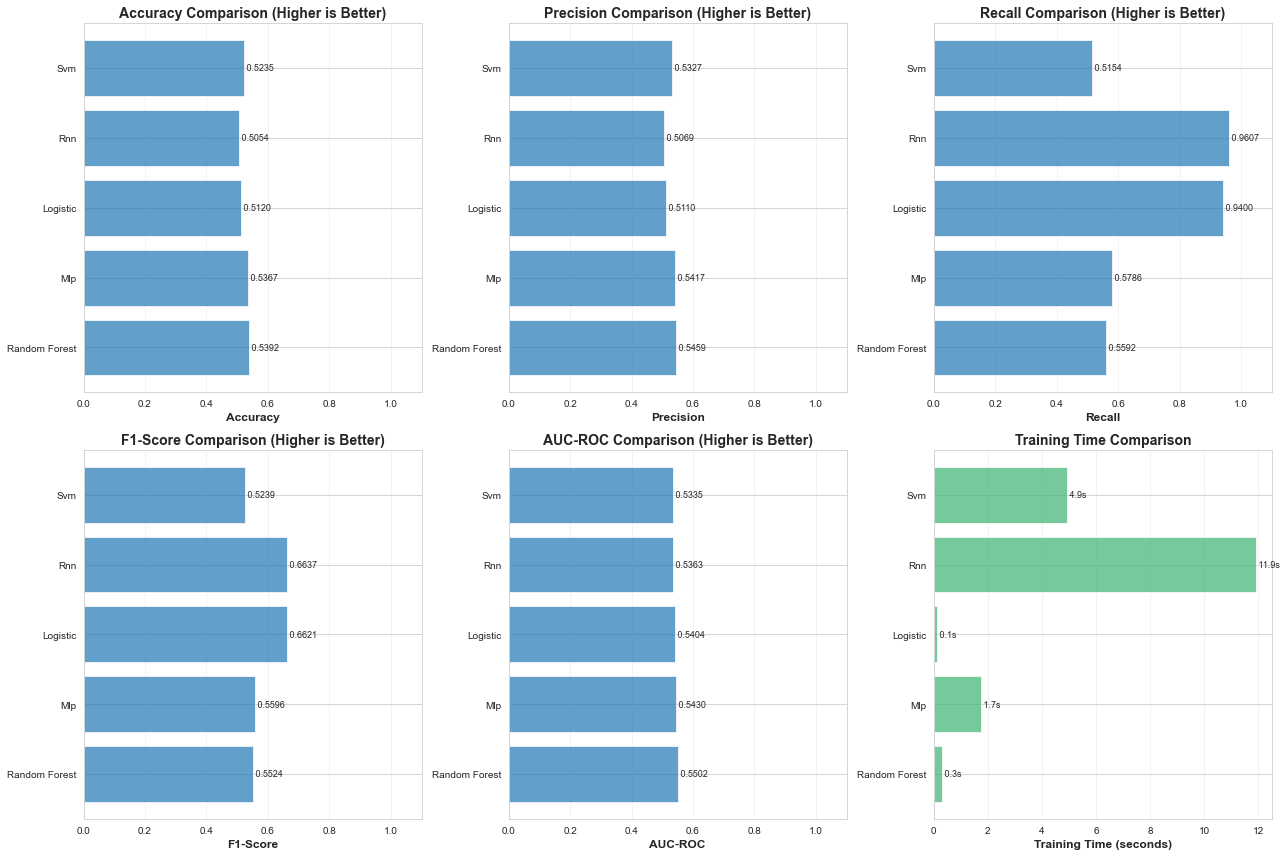


Best Model (AUC-ROC): Random Forest
   Accuracy: 0.5392
   Precision: 0.5459
   Recall: 0.5592
   F1-Score: 0.5524
   AUC-ROC: 0.5502


In [8]:
# Visualize model comparison
if len(results) > 0 and 'comparison_df' in locals():
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    models = comparison_df['Model'].values
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
    
    # Plot each metric
    for idx, metric in enumerate(metrics_to_plot):
        if idx < len(axes):
            values = comparison_df[metric].values
            # Handle NaN values
            valid_mask = ~np.isnan(values)
            valid_models = models[valid_mask]
            valid_values = values[valid_mask]
            
            if len(valid_values) > 0:
                axes[idx].barh(valid_models, valid_values, alpha=0.7)
                axes[idx].set_xlabel(metric, fontsize=12, fontweight='bold')
                axes[idx].set_title(f'{metric} Comparison (Higher is Better)', fontsize=14, fontweight='bold')
                axes[idx].grid(True, alpha=0.3, axis='x')
                axes[idx].set_xlim([0, 1.1])
                for i, v in enumerate(valid_values):
                    axes[idx].text(v, i, f' {v:.4f}', va='center', fontsize=9)
    
    # Training time comparison (if available)
    time_values = []
    time_labels = []
    for model in models:
        model_key = model.lower().replace(' ', '_')
        if model_key in model_times:
            time_values.append(model_times[model_key])
            time_labels.append(f"{model_times[model_key]:.1f}s")
        else:
            time_values.append(0)
            time_labels.append("N/A")
    
    if any(time_values) and len(axes) > 5:
        axes[5].barh(models, time_values, alpha=0.7, color='mediumseagreen')
        axes[5].set_xlabel('Training Time (seconds)', fontsize=12, fontweight='bold')
        axes[5].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
        axes[5].grid(True, alpha=0.3, axis='x')
        for i, (v, label) in enumerate(zip(time_values, time_labels)):
            if v > 0:
                axes[5].text(v, i, f' {label}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Display best model
    best_model = comparison_df.iloc[0]
    print(f"\nBest Model (AUC-ROC): {best_model['Model']}")
    print(f"   Accuracy: {best_model['Accuracy']:.4f}")
    print(f"   Precision: {best_model['Precision']:.4f}")
    print(f"   Recall: {best_model['Recall']:.4f}")
    print(f"   F1-Score: {best_model['F1-Score']:.4f}")
    print(f"   AUC-ROC: {best_model['AUC-ROC']:.4f}" if not np.isnan(best_model['AUC-ROC']) else f"   AUC-ROC: N/A")
else:
    print("Warning: Please run the model training cell first to generate visualizations.")

## ROC Curves Comparison

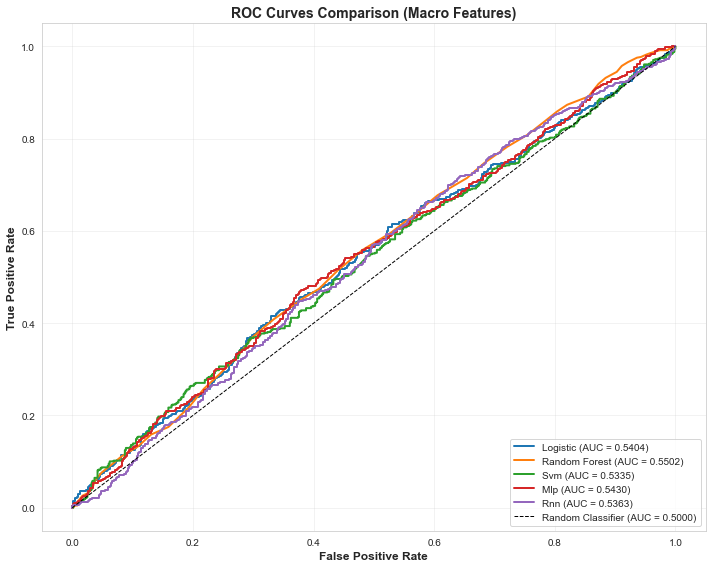

In [9]:
# Plot ROC curves for all models
if len(results) > 0:
    from sklearn.metrics import roc_curve, roc_auc_score
    
    plt.figure(figsize=(10, 8))
    
    for model_name, result in results.items():
        if 'y_proba' in result and result['y_proba'] is not None:
            try:
                y_proba_raw = result['y_proba']
                stored_auc = result.get('auc', np.nan)
                
                # Extract positive class probability
                y_proba_array = np.array(y_proba_raw)
                if len(y_proba_array.shape) > 1:
                    y_proba_positive = y_proba_array[:, 1] if y_proba_array.shape[1] > 1 else y_proba_array.flatten()
                else:
                    y_proba_positive = y_proba_array
                
                y_proba_positive = y_proba_positive.flatten()
                
                if model_name == 'rnn':
                    # RNN uses sequences which create different alignment
                    if 'y_test_aligned' not in result:
                        # Fallback alignment for RNN
                        seq_length = 10
                        pred_len = len(y_proba_positive)
                        aligned_y = np.array(test_y_aligned[seq_length - 1:]).flatten()
                        if len(aligned_y) >= pred_len:
                            y_true_for_roc = aligned_y[:pred_len]
                        else:
                            raise ValueError(f"Cannot align RNN test_y - aligned length too short")
                    else:
                        y_true_stored = np.array(result['y_test_aligned'])
                        y_true_for_roc = y_true_stored.flatten()
                        
                        stored_len = len(y_true_for_roc)
                        pred_len = len(y_proba_positive)
                        
                        if stored_len != pred_len:
                            seq_length = 10
                            aligned_y = np.array(test_y_aligned[seq_length - 1:]).flatten()
                            if len(aligned_y) >= pred_len:
                                y_true_for_roc = aligned_y[:pred_len]
                            else:
                                raise ValueError(f"Cannot plot RNN ROC: stored y_test_aligned ({stored_len}) != predictions ({pred_len})")
                else:
                    y_true_for_roc = np.array(test_y_aligned).flatten()
                
                # Verify lengths match
                if len(y_proba_positive) != len(y_true_for_roc):
                    if model_name == 'rnn':
                        raise ValueError(f"RNN alignment error: y_proba ({len(y_proba_positive)}) != y_true ({len(y_true_for_roc)})")
                    else:
                        min_len = min(len(y_proba_positive), len(y_true_for_roc))
                        y_proba_positive = y_proba_positive[:min_len]
                        y_true_for_roc = y_true_for_roc[:min_len]
                
                # Calculate ROC curve
                if len(y_proba_positive) > 0 and len(y_proba_positive) == len(y_true_for_roc):
                    calculated_auc = roc_auc_score(y_true_for_roc, y_proba_positive)
                    
                    if model_name == 'rnn' and not np.isnan(stored_auc):
                        auc_diff = abs(calculated_auc - stored_auc)
                        if auc_diff > 0.001:
                            if len(y_proba_array.shape) > 1 and y_proba_array.shape[1] > 1:
                                y_proba_alt = y_proba_array[:, 0].flatten()
                                calculated_auc_alt = roc_auc_score(y_true_for_roc, y_proba_alt)
                                if abs(calculated_auc_alt - stored_auc) < auc_diff:
                                    y_proba_positive = y_proba_alt
                                    calculated_auc = calculated_auc_alt
                    
                    fpr, tpr, _ = roc_curve(y_true_for_roc, y_proba_positive)
                    auc = stored_auc if not np.isnan(stored_auc) else calculated_auc
                    
                    label = f"{model_name.replace('_', ' ').title()}"
                    if not np.isnan(auc):
                        label += f" (AUC = {auc:.4f})"
                    else:
                        label += " (AUC = N/A)"
                    
                    plt.plot(fpr, tpr, label=label, linewidth=2)
                else:
                    print(f"Warning: Skipping ROC curve for {model_name} - invalid data")
            except Exception as e:
                print(f"Warning: Could not plot ROC curve for {model_name}: {str(e)}")
    
    # Plot diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5000)', linewidth=1)
    
    plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    plt.title('ROC Curves Comparison (Macro Features)', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Warning: Please run the model training cell first to generate ROC curves.")

## Confusion Matrices

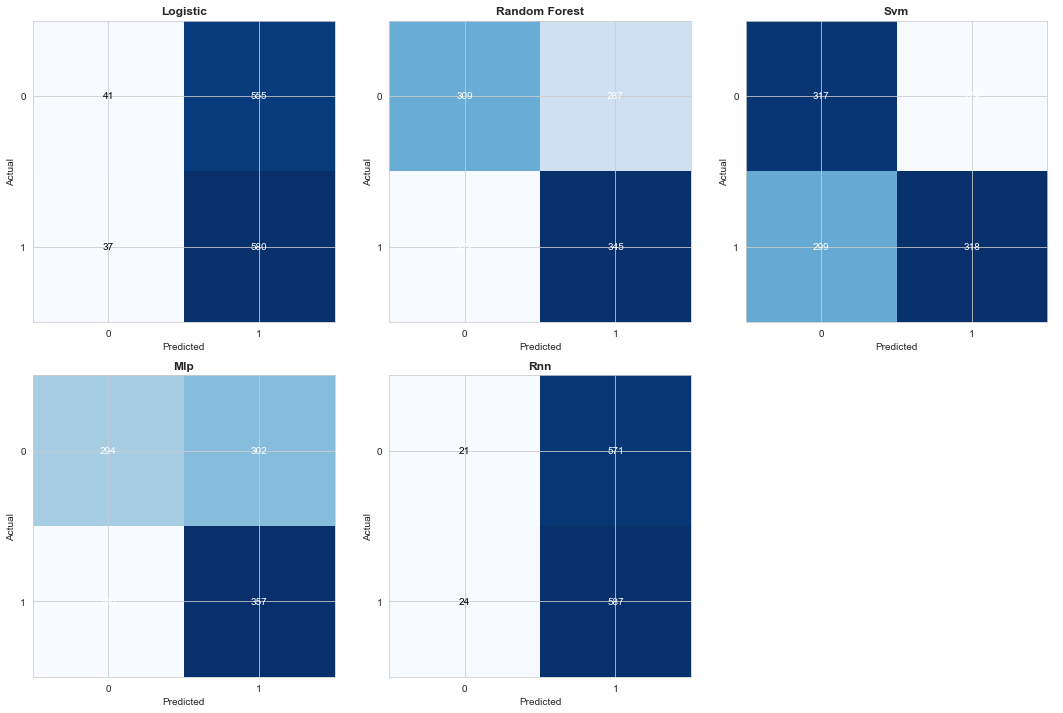

In [10]:
# Plot confusion matrices for all models
if len(results) > 0:
    from sklearn.metrics import confusion_matrix
    
    n_models = len(results)
    n_cols = 3
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_models == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, (model_name, result) in enumerate(results.items()):
        if idx < len(axes):
            y_pred = result['y_pred']
            
            # Get corresponding true labels
            if model_name == 'rnn':
                if 'y_test_aligned' in result:
                    y_true_for_cm = np.array(result['y_test_aligned']).flatten()
                else:
                    seq_length = 10
                    pred_len = len(y_pred)
                    aligned_y = np.array(test_y_aligned[seq_length - 1:]).flatten()
                    if len(aligned_y) >= pred_len:
                        y_true_for_cm = aligned_y[:pred_len]
                    else:
                        y_true_for_cm = test_y_aligned
            else:
                y_true_for_cm = np.array(test_y_aligned).flatten()
            
            # Ensure lengths match
            if len(y_pred) != len(y_true_for_cm):
                min_len = min(len(y_pred), len(y_true_for_cm))
                y_pred = y_pred[:min_len]
                y_true_for_cm = y_true_for_cm[:min_len]
            
            cm = confusion_matrix(y_true_for_cm, y_pred)
            
            # Use matplotlib imshow instead of seaborn
            im = axes[idx].imshow(cm, interpolation='nearest', cmap='Blues')
            
            # Add text annotations
            thresh = cm.max() / 2.
            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    axes[idx].text(j, i, format(cm[i, j], 'd'),
                                 ha="center", va="center",
                                 color="white" if cm[i, j] > thresh else "black")
            
            axes[idx].set_title(f"{model_name.replace('_', ' ').title()}", fontsize=12, fontweight='bold')
            axes[idx].set_ylabel('Actual')
            axes[idx].set_xlabel('Predicted')
            axes[idx].set_xticks(range(cm.shape[1]))
            axes[idx].set_yticks(range(cm.shape[0]))
    
    # Hide extra subplots
    for idx in range(n_models, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("Warning: Please run the model training cell first to generate confusion matrices.")

## Save Results for Comparison

Save results to file for later comparison with baseline models in `compare_baseline_vs_macro.ipynb`.


In [12]:
# Save macro results for comparison
import pickle
from pathlib import Path

# Ensure results and test_y_aligned exist
if 'results' in locals() and 'test_y_aligned' in locals() and len(results) > 0:
    # Save results to notebooks directory
    output_file = Path("macro_classification_results.pkl")
    macro_results_to_save = {
        'results': results.copy(),
        'test_y': test_y_aligned.copy(),
    }
    
    # Optionally save comparison_df and model_times if available
    if 'comparison_df' in locals():
        macro_results_to_save['comparison_df'] = comparison_df.copy()
    if 'model_times' in locals():
        macro_results_to_save['model_times'] = model_times.copy()
    
    with open(output_file, 'wb') as f:
        pickle.dump(macro_results_to_save, f)
    
    print(f"✓ Macro results saved to: {output_file}")
    print(f"  Saved {len(results)} models")
    print(f"  Test set size: {len(test_y_aligned)}")
    print(f"  Models saved: {list(results.keys())}")
    print(f"\nYou can now load these results in compare_baseline_vs_macro.ipynb")
else:
    print("⚠ Warning: 'results' or 'test_y_aligned' not found.")
    print("  Please run the model training cells first before saving results.")


✓ Macro results saved to: macro_classification_results.pkl
  Saved 5 models
  Test set size: 1213
  Models saved: ['logistic', 'random_forest', 'svm', 'mlp', 'rnn']

You can now load these results in compare_baseline_vs_macro.ipynb
